<a href="https://colab.research.google.com/github/xdderekchen/ML/blob/master/EDA_JH_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Data Analysis

(https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data) provides realtime information and counts cases of COVID-19 coronavirus in China, as well as around the world, including numbers of deaths, recovered patients, and countries affected

In this post, we provide sample Python code to pull data from JH and perform very basic data processing and basic analysis. 

In [0]:
#Import libraries we need
import  pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta,date
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Analysis using global data

Functions to pull data and tranform data.

In [0]:
JH_Data_ROOT = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data"

#JH dataset get format changed on March 23. Old files are not updated. Using the following new files (2, instead of 3)
TS_File_Confirm    =  os.path.join(JH_Data_ROOT, "csse_covid_19_time_series", "time_series_covid19_confirmed_global.csv")
TS_File_Death      =  os.path.join(JH_Data_ROOT, "csse_covid_19_time_series", "time_series_covid19_deaths_global.csv")
TS_File_Recovered  =  os.path.join(JH_Data_ROOT, "csse_covid_19_time_series", "time_series_covid19_recovered_global.csv")

Daily_File_ROOT =  os.path.join(JH_Data_ROOT, "csse_covid_19_daily_reports")
#File name will be in the format similar to 03-23-2020.csv

def read_JH_TS_file(filePath, asCumValue=True):
    df = pd.read_csv(filePath)
    df.rename(columns={'Province/State': 'State', 'Country/Region' : 'Country'}, inplace=True)
    df['State'] = df['State'].fillna("")
    colnames = df.columns
    if asCumValue == True:
       return (df)
    else:
       #prepare a numpy matrix as the placehold, initialized as 0
       difs = np.zeros((df.shape[0], df.shape[1]-5), dtype=int)
       for i in range(5, df.shape[1]):
           value = df.iloc[:, i] -  df.iloc[:, i-1]
           value[value <0] =0
           difs[:, i-5] = value

       difs = pd.DataFrame(difs, columns=colnames[5:])
       df_delta = pd.concat([df.iloc[:, :4], difs], axis=1)
       return (df_delta)

def melt_JH_TS(df, value_name):
    dfo = pd.melt(df, id_vars=['State',	'Country',	'Lat',	'Long'], var_name="Date", value_name=value_name)
    dfo['Date'] = dfo['Date'].astype('datetime64[ns]')
    dfo.sort_values(by=['Country', 'State',	 'Date'],  inplace=True)
    dfo = dfo.reset_index(drop=True)
    return (dfo)


def merge_confirm_death_recover(TS_File_Confirm, TS_File_Death, asCumValue=True):
    Data_Confirm  = read_JH_TS_file(TS_File_Confirm, asCumValue)
    Data_Death    = read_JH_TS_file(TS_File_Death, asCumValue)
    Data_Recovered= read_JH_TS_file(TS_File_Recovered, asCumValue)  #this file is not supported after March 23

    Data_Confirm   = melt_JH_TS(Data_Confirm, "Confirm")
    Data_Death     = melt_JH_TS(Data_Death, "Death")
    Data_Recovered = melt_JH_TS(Data_Recovered, "Recovered")

    data = pd.merge(Data_Confirm, Data_Death[["Country", "State", "Date", "Death"]],  on=["Country", "State", "Date"],  how="inner")
    data = pd.merge(data,     Data_Recovered[["Country", "State", "Date", "Recovered"]], on=["Country", "State", "Date"],  how="inner")
    data = data.sort_values(["Country", "State", "Date"])

    world_Confirm   = Data_Confirm.groupby(["Date"]).agg( Confirm =( "Confirm", np.sum)).reset_index()
    world_Death     = Data_Death.groupby(["Date"]).agg( Death =( "Death", np.sum)).reset_index()
    world_Recovered = Data_Recovered.groupby(["Date"]).agg( Recovered =( "Recovered", np.sum)).reset_index()

    world_data = pd.merge(world_Confirm, world_Death,  on="Date",  how="inner")
    world_data = pd.merge(world_data, world_Recovered, on="Date",  how="inner").sort_values(["Date"])

    country_Confirm     = Data_Confirm.groupby(["Country", "Date"]).agg( Confirm =( "Confirm", np.sum)).reset_index()
    country_Death       = Data_Death.groupby(["Country", "Date"]).agg( Death =( "Death", np.sum)).reset_index()
    country_Recovered   = Data_Recovered.groupby(["Country", "Date"]).agg( Recovered =( "Recovered", np.sum)).reset_index()

    country_data = pd.merge(country_Confirm, country_Death,  on=["Country", "Date"],  how="inner")
    country_data = pd.merge(country_data, country_Recovered, on=["Country", "Date"],  how="inner").sort_values(["Country", "Date"])

    return (world_data, country_data, data)


def data_after_X_cases(df, X, groupby_cols):
    newdf = df[df["Confirm"] >= X].copy()
    newdf["RowID_Group"] = newdf.groupby(groupby_cols).cumcount()+1
    return (newdf)

def get_countries_by_order_confirm(df, count=20):
   out = df.groupby("Country").tail(1)
   out = out.sort_values(by='Confirm', ascending=False)
   out = out[["Country", "Confirm"]].reset_index(drop=True).reset_index()
   return (out[out["index"] <= count].copy())


In [0]:
world_data, country_data, data = merge_confirm_death_recover(TS_File_Confirm, TS_File_Death, asCumValue=False)
data[data.Country=="US"]

,State,Country,Lat,Long,Date,Confirm,Death,Recovered
18675,,US,37.0902,-95.7129,2020-01-23,0,0,0
18676,,US,37.0902,-95.7129,2020-01-24,1,0,0
18677,,US,37.0902,-95.7129,2020-01-25,0,0,0
18678,,US,37.0902,-95.7129,2020-01-26,3,0,0
18679,,US,37.0902,-95.7129,2020-01-27,0,0,0
...,...,...,...,...,...,...,...,...
18753,,US,37.0902,-95.7129,2020-04-10,35098,2108,3380
18754,,US,37.0902,-95.7129,2020-04-11,29861,1877,2480
18755,,US,37.0902,-95.7129,2020-04-12,28917,1557,1718
18756,,US,37.0902,-95.7129,2020-04-13,25306,1509,10494


In [0]:
world_data, country_data, data = merge_confirm_death_recover(TS_File_Confirm, TS_File_Death, asCumValue=True)
world_data_nc, country_data_nc, data_nc = merge_confirm_death_recover(TS_File_Confirm, TS_File_Death, asCumValue=False)

country_data_10 = data_after_X_cases(df=country_data, X=10, groupby_cols= ["Country"])
country_data_10

country_data_100 = data_after_X_cases(df=country_data, X=100, groupby_cols= ["Country"])
country_data_100.head(10)

country_ranks_f10s = get_countries_by_order_confirm(country_data_100, 10)

country_data_100_10 = pd.merge(country_data_100, country_ranks_f10s[["Country", "index"]],  on=["Country"],  how="inner")
country_data_100_10.sort_values(by=["index", "Country", "Date"], inplace=True)

country_data_100_10 = pd.merge( country_data_100_10, country_data_nc,  on=["Country", "Date"], how="inner")
country_data_100_10.rename(columns={'Confirm_x': 'Confirm', 'Confirm_y' : 'Confirm_new', "Death_x": "Death", "Death_y": "Death"}, inplace=True)
  
country_data_100_10

,Country,Date,Confirm,Death,Recovered_x,RowID_Group,index,Confirm_new,Death,Recovered_y
0,US,2020-03-03,118,7,7,1,0,20,1,0
1,US,2020-03-04,149,11,7,2,0,31,4,0
2,US,2020-03-05,217,12,7,3,0,68,1,0
3,US,2020-03-06,262,14,7,4,0,45,2,0
4,US,2020-03-07,402,17,7,5,0,140,3,0
...,...,...,...,...,...,...,...,...,...,...
505,Netherlands,2020-04-10,23249,2520,287,36,10,1346,117,9
506,Netherlands,2020-04-11,24571,2653,291,37,10,1322,133,4
507,Netherlands,2020-04-12,25746,2747,295,38,10,1175,94,4
508,Netherlands,2020-04-13,26710,2833,295,39,10,964,86,0


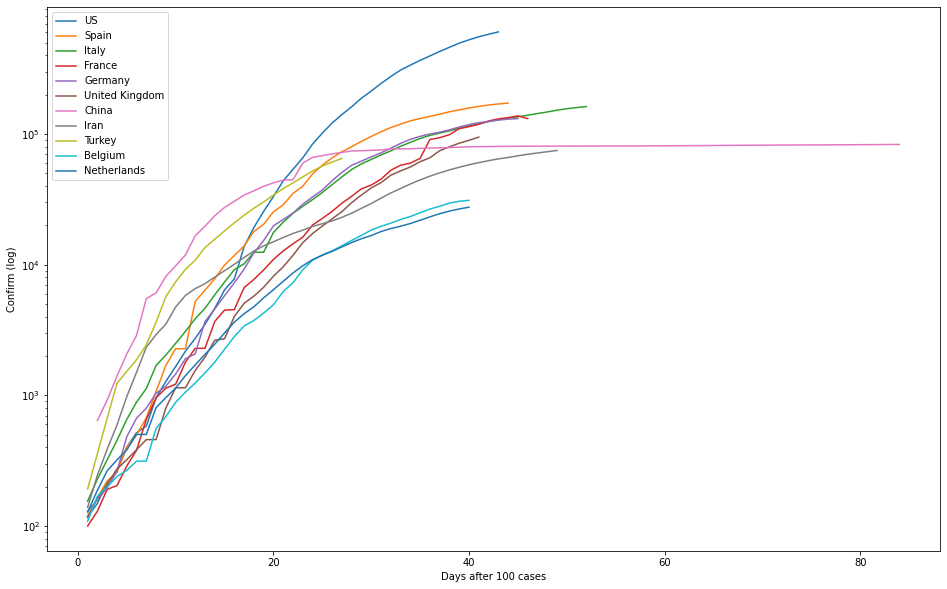

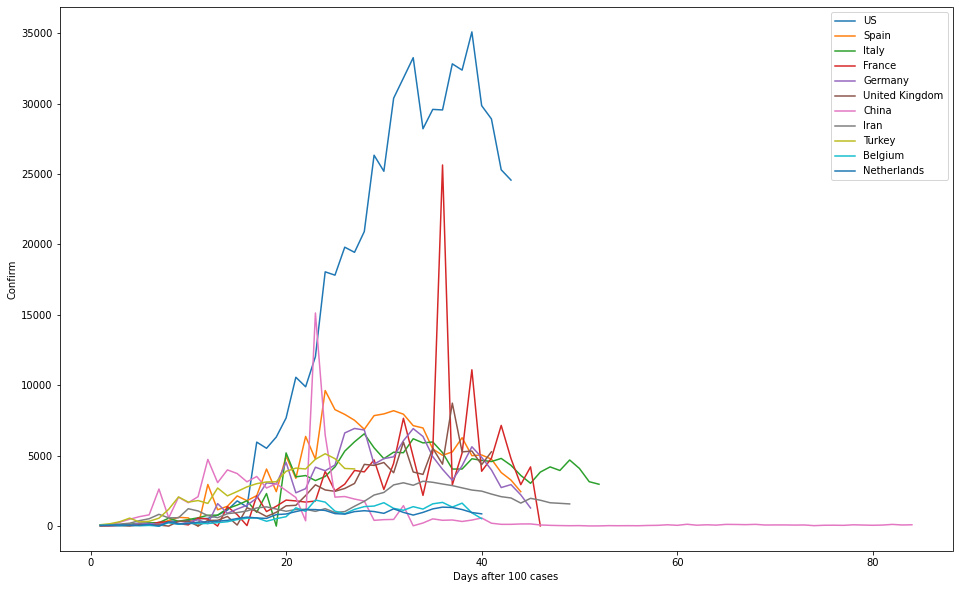

In [0]:
import matplotlib.pyplot as plt

def plot_growth(df, Y, usingLog=True):
  fig,ax = plt.subplots(figsize=(16, 10))

  for name in df.Country.unique():
      sel_df = df[df.Country==name]
      ax.plot(sel_df.RowID_Group, sel_df[Y],label=name)

  ax.set_xlabel("Days after 100 cases")
  if usingLog == True:
    ax.set_ylabel("Confirm (log)")
    ax.set_yscale('log')
  else:
    ax.set_ylabel("Confirm")
  ax.legend(loc='best')
  plt.show()

plot_growth(country_data_100_10, "Confirm", True)
plot_growth(country_data_100_10, "Confirm_new", False)

In [0]:
import plotly.express as px

df = country_data_100_10.query("RowID_Group<50")
fig = px.line(df, x="RowID_Group", y="Confirm", color="Country", log_y=True, title="Top 10 countries, days after 100 cases",
              labels = {"RowID_Group":"Days after 100 cases", "Confirm": "Confirm in log scale"},
              line_group="Country", hover_name="Country")
fig.show()

fig = px.line(df, x="RowID_Group", y="Confirm_new", color="Country", log_y=True, title="Top 10 countries, days after 100 cases",
              labels = {"RowID_Group":"Days after 100 cases", "Confirm_new": "Confirm New Cases"},
              line_group="Country", hover_name="Country")
fig.show()

df

NameError: ignored

## Data Analysis using us data

In [0]:
JH_Data_ROOT = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data"

#JH dataset get format changed on March 23. Old files are not updated. Using the following new files (2, instead of 3)
US_File_Confirm    =  os.path.join(JH_Data_ROOT, "csse_covid_19_time_series", "time_series_covid19_confirmed_US.csv")
US_File_Death      =  os.path.join(JH_Data_ROOT, "csse_covid_19_time_series", "time_series_covid19_deaths_US.csv")


def read_JH_TS_file_US(filePath, asCumValue=True):
    df = pd.read_csv(filePath)
    df.rename(columns={'Province_State':'State', 
                       'Country_Region':'Country', 
                       'Long_':"Long", 
                       "Admin2":"County"}, inplace=True)
    df['State'] = df['State'].fillna("")
    df['County'] = df['County'].fillna("")
    df.drop(['UID',	'iso2',	'iso3','code3',	'FIPS','Combined_Key'], axis=1, inplace=True)
    if ("Population" in df.columns):
       df.drop(['Population'], axis=1, inplace=True)

    df = df.query("Country=='US'")
    df.drop(['Country'], axis=1, inplace=True)
    if asCumValue == True:
       return (df)
    else:
       #prepare a numpy matrix as the placehold, initialized as 0
       colnames = df.columns

       difs = np.zeros((df.shape[0], df.shape[1]-5), dtype=int)
       for i in range(5, df.shape[1]):
           value = df.iloc[:, i] -  df.iloc[:, i-1]
           value[value <0] =0
           difs[:, i-5] = value
       
       difs = pd.DataFrame(difs, columns=colnames[5:])
       df_delta = pd.concat([df.iloc[:, :4], difs], axis=1)
       return (df_delta)

def get_population(filePath):
    df = pd.read_csv(filePath)
    df.rename(columns={'Province_State':'State', 
                       'Country_Region':'Country', 
                       'Long_':"Long", 
                       "Admin2":"County"}, inplace=True)
    df['State'] = df['State'].fillna("")
    df['County'] = df['County'].fillna("")
    return (df[df.Country=='US'][['State', 'County', 'Population']].reset_index(drop=True))
    
def melt_JH_TS_US(df, value_name):
                    
    dfo = pd.melt(df, id_vars=['State',	'County',	'Lat',	'Long'], var_name="Date", value_name=value_name)
    dfo['Date'] = dfo['Date'].astype('datetime64[ns]')
    dfo.sort_values(by=['State', 'County',	 'Date'],  inplace=True)
    dfo = dfo.reset_index(drop=True)
    return (dfo)


def merge_confirm_death_US(TS_File_Confirm, TS_File_Death, asCumValue=True):
    Data_Confirm  = read_JH_TS_file_US(US_File_Confirm, asCumValue)
    Data_Death    = read_JH_TS_file_US(US_File_Death, asCumValue)
   
    Data_Confirm   = melt_JH_TS_US(Data_Confirm, "Confirm")
    Data_Death     = melt_JH_TS_US(Data_Death, "Death")
   
    data = pd.merge(Data_Confirm, Data_Death[['State', 'County',"Date", "Death"]],  on=["State", 'County', "Date"],  how="inner")
    data = data.sort_values(['State', 'County', "Date"])

    country_Confirm     = Data_Confirm.groupby([ "Date"]).agg( Confirm =( "Confirm", np.sum)).reset_index()
    country_Death       = Data_Death.groupby([ "Date"]).agg( Death =( "Death", np.sum)).reset_index()
    country_data = pd.merge(country_Confirm, country_Death,  on=[ "Date"],  how="inner")
  
    state_Confirm     = Data_Confirm.groupby(["State", "Date"]).agg( Confirm =( "Confirm", np.sum)).reset_index()
    state_Death       = Data_Death.groupby(["State", "Date"]).agg( Death =( "Death", np.sum)).reset_index()
   
    state_data       = pd.merge(state_Confirm, state_Death,  on=["State", "Date"],  how="inner")
   

    return (country_data, state_data, data)


def US_data_after_X_cases(df, X, groupby_cols):
    newdf = df[df["Confirm"] >= X].copy()
    newdf["RowID_Group"] = newdf.groupby(groupby_cols).cumcount()+1
    return (newdf)

def get_US_by_order_confirm(df, count=20):
   out = df.groupby("State").tail(1)
   out = out.sort_values(by='Confirm', ascending=False)
   out = out[["State", "Confirm"]].reset_index(drop=True).reset_index()
   return (out[out["index"] <= count].copy())

Data_Death    = read_JH_TS_file_US(US_File_Death, True)
Data_Death[Data_Death.State=='New York'][["4/5/20", "4/6/20"]]

,4/5/20,4/6/20
1833,8,8
1834,1,1
1835,0,0
1836,5,5
1837,0,0
...,...,...
1892,67,211
1893,1,1
1894,0,0
3181,0,0


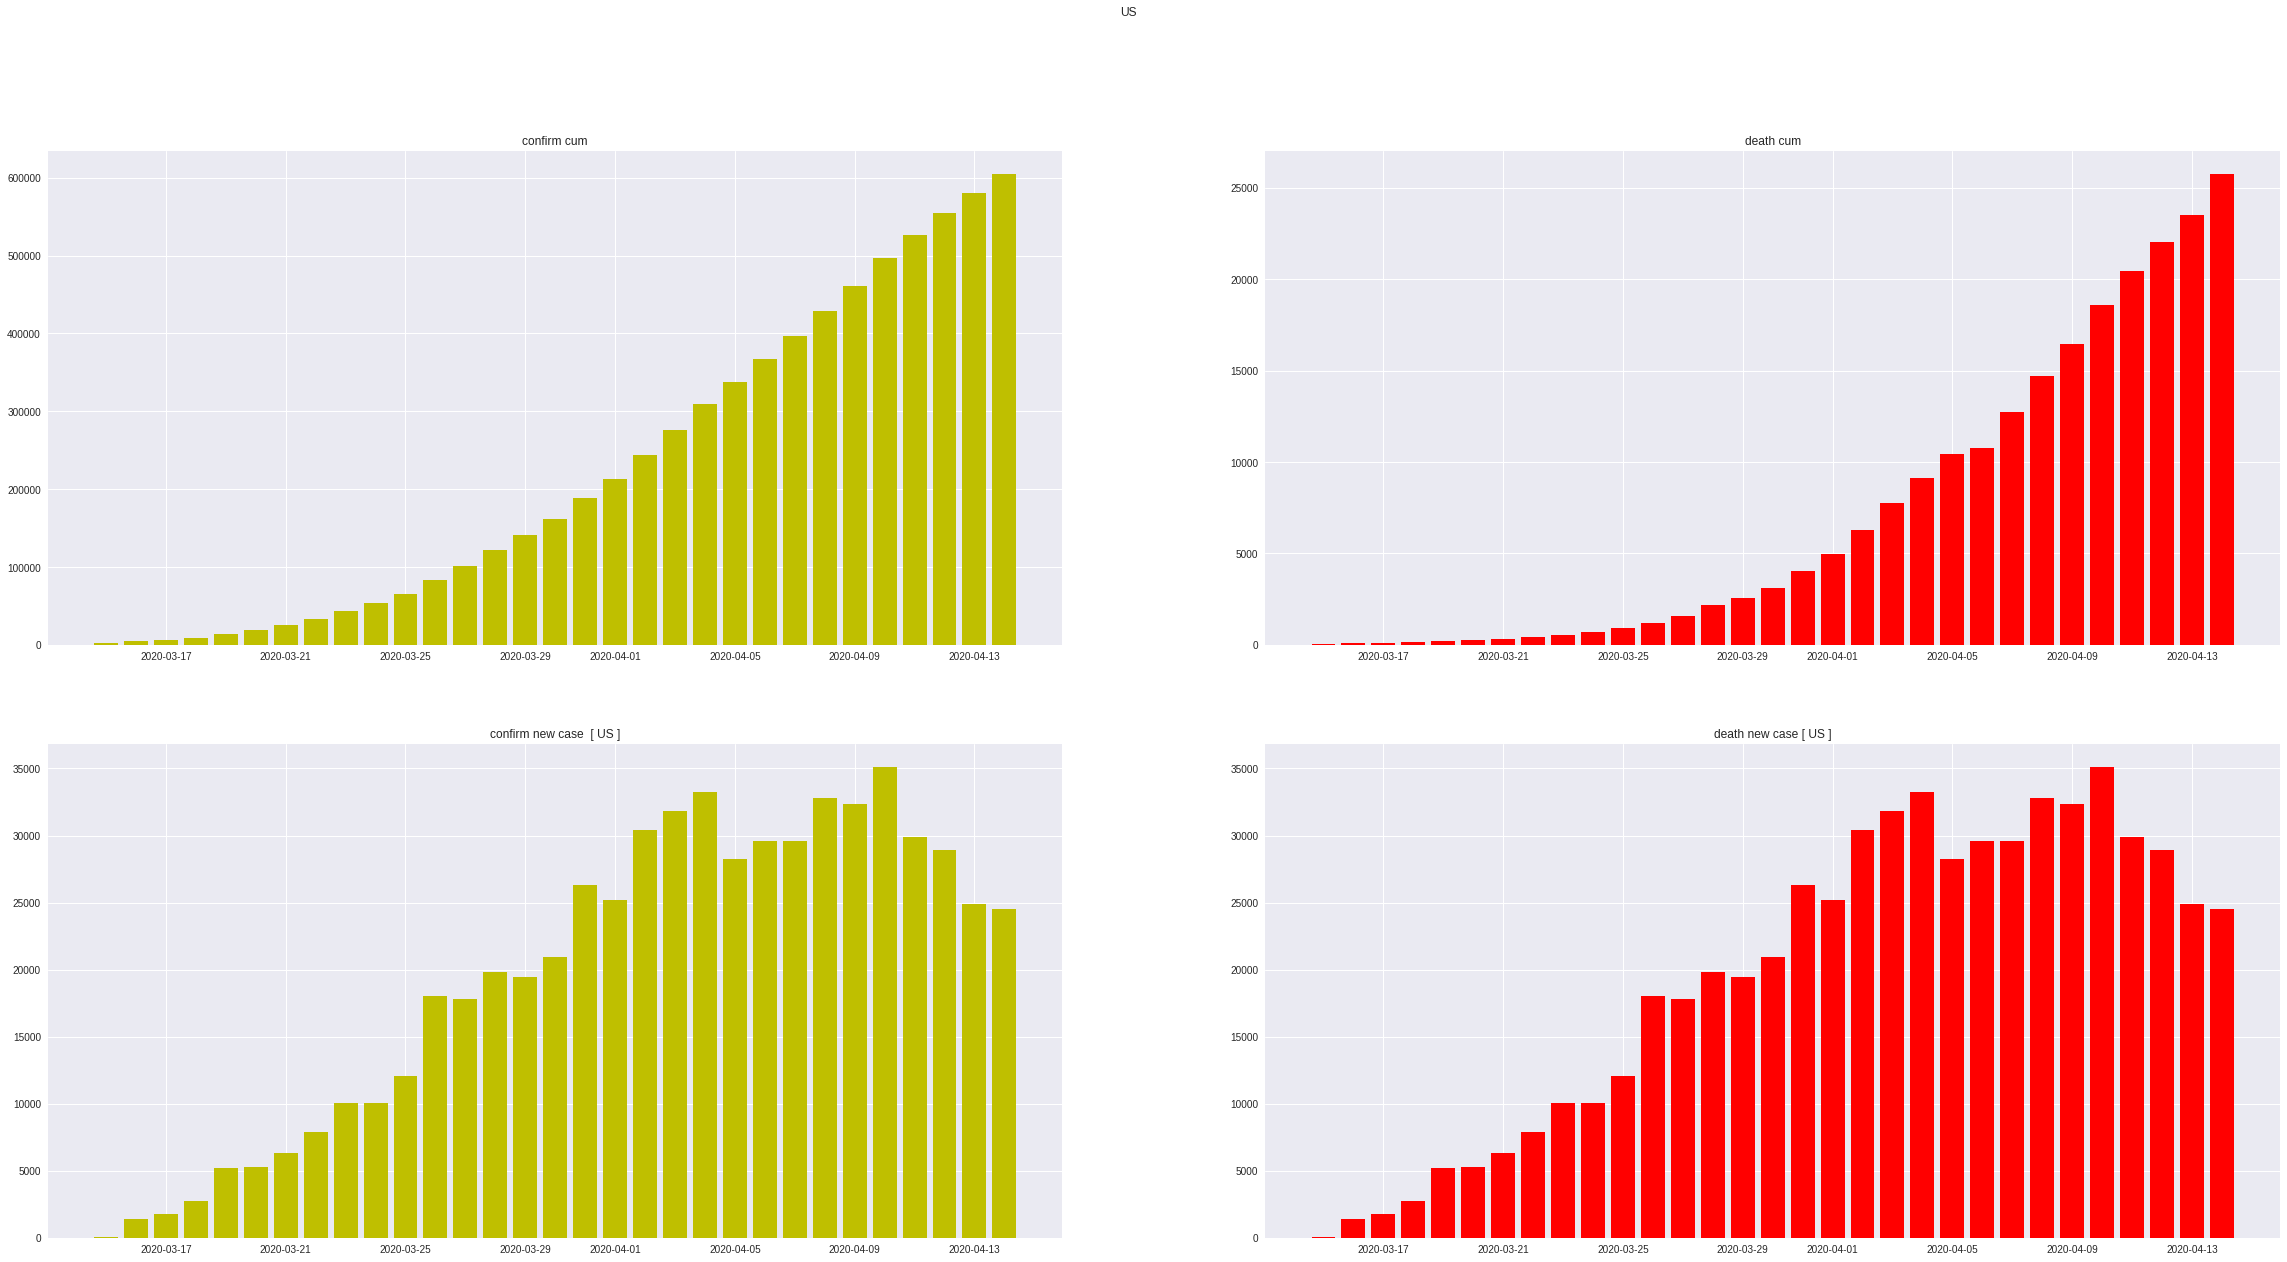

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


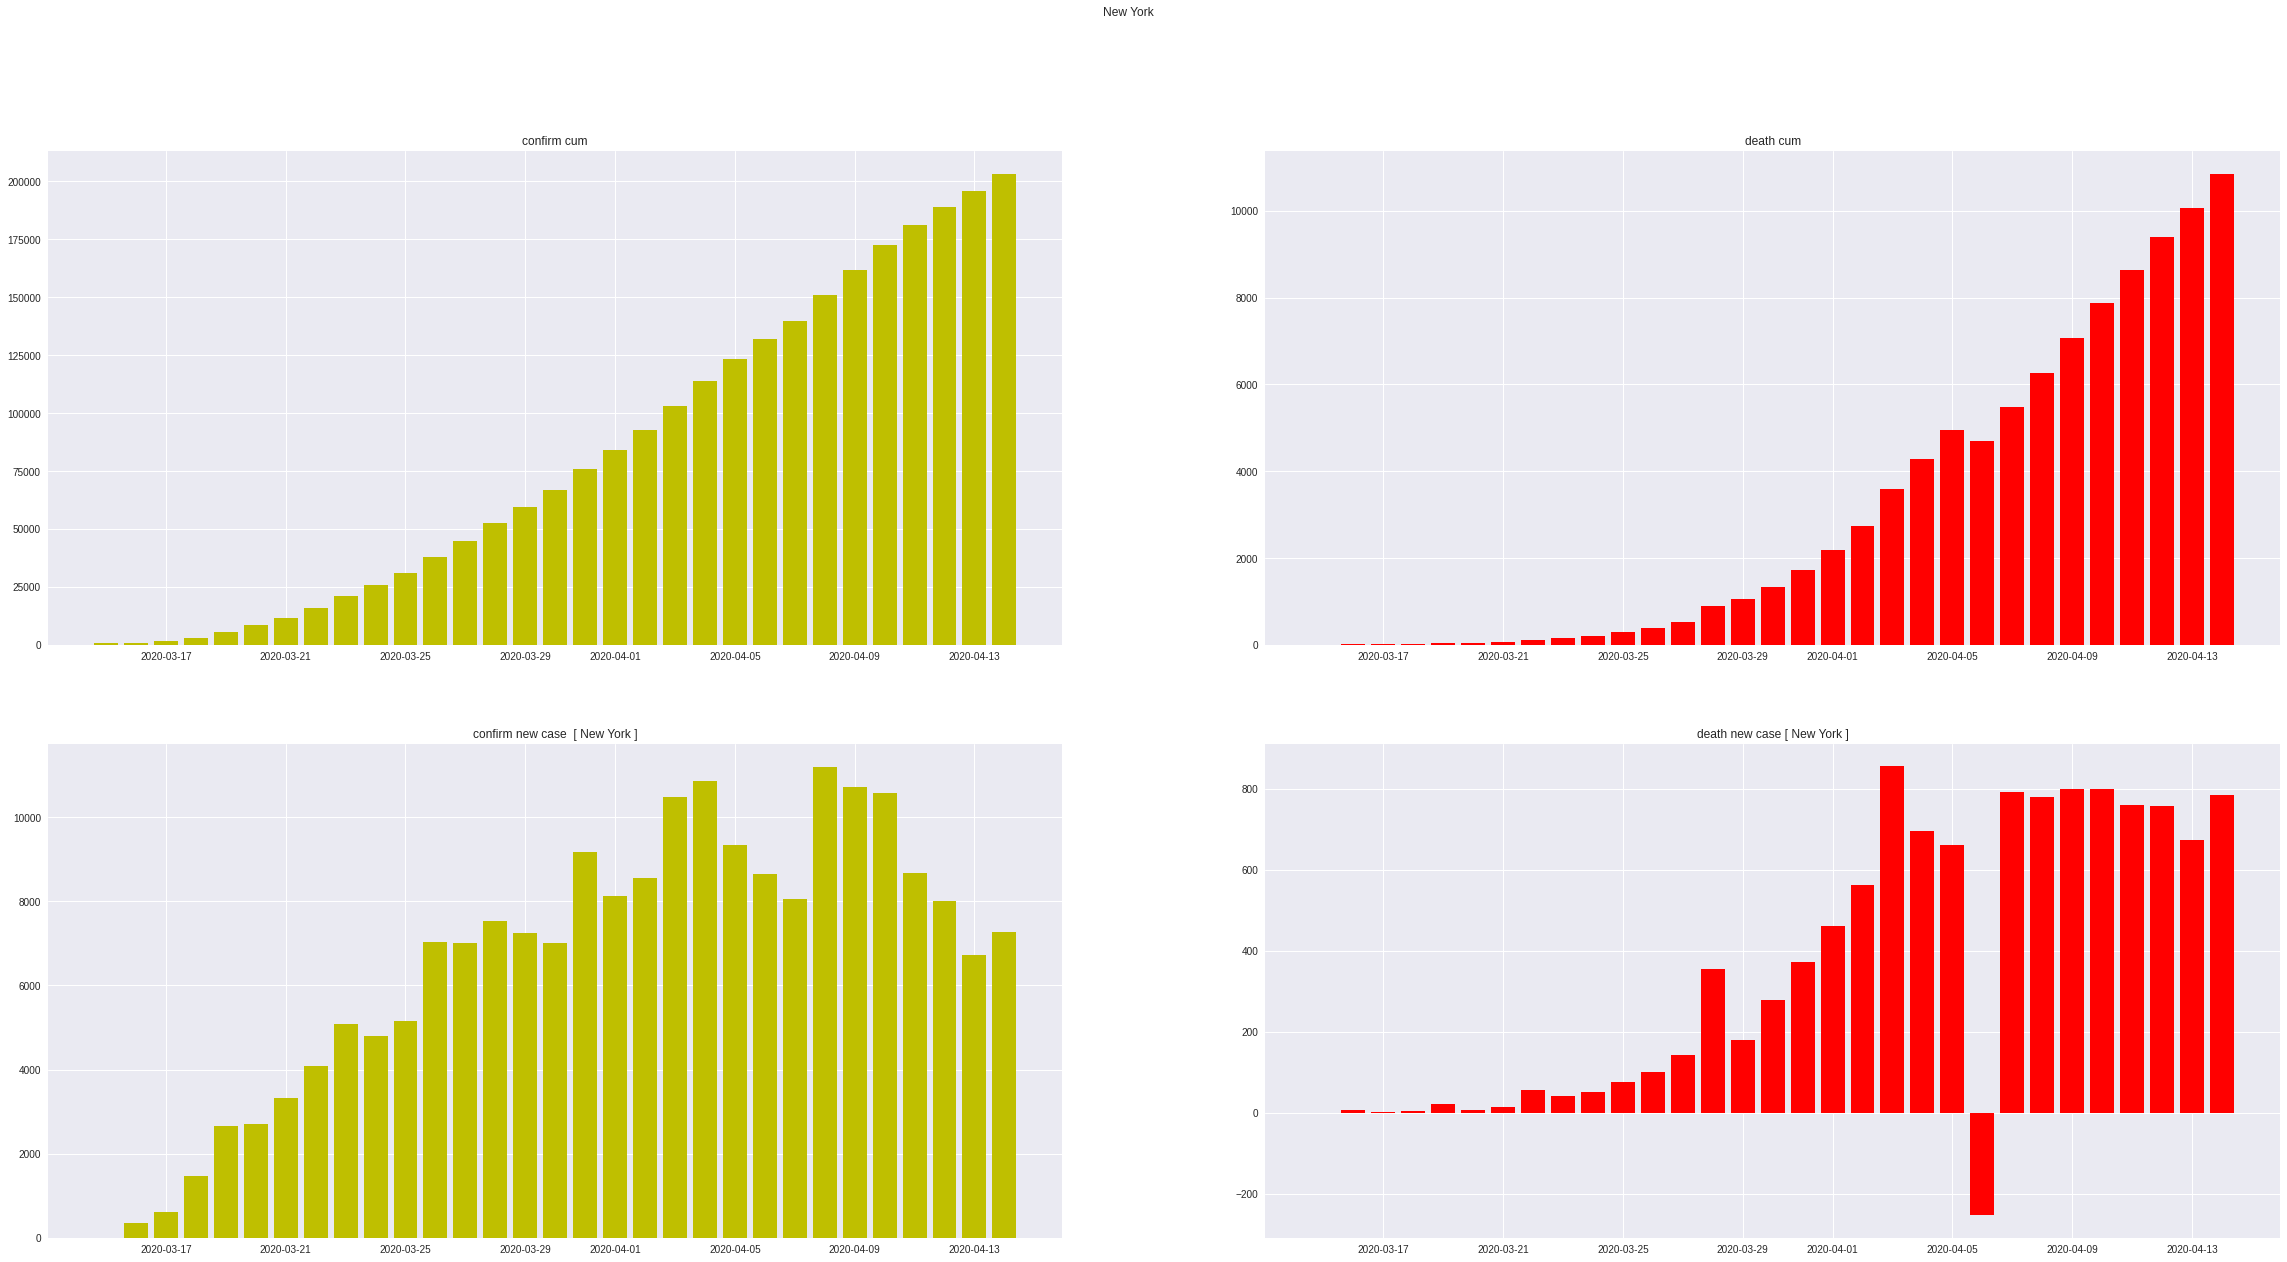

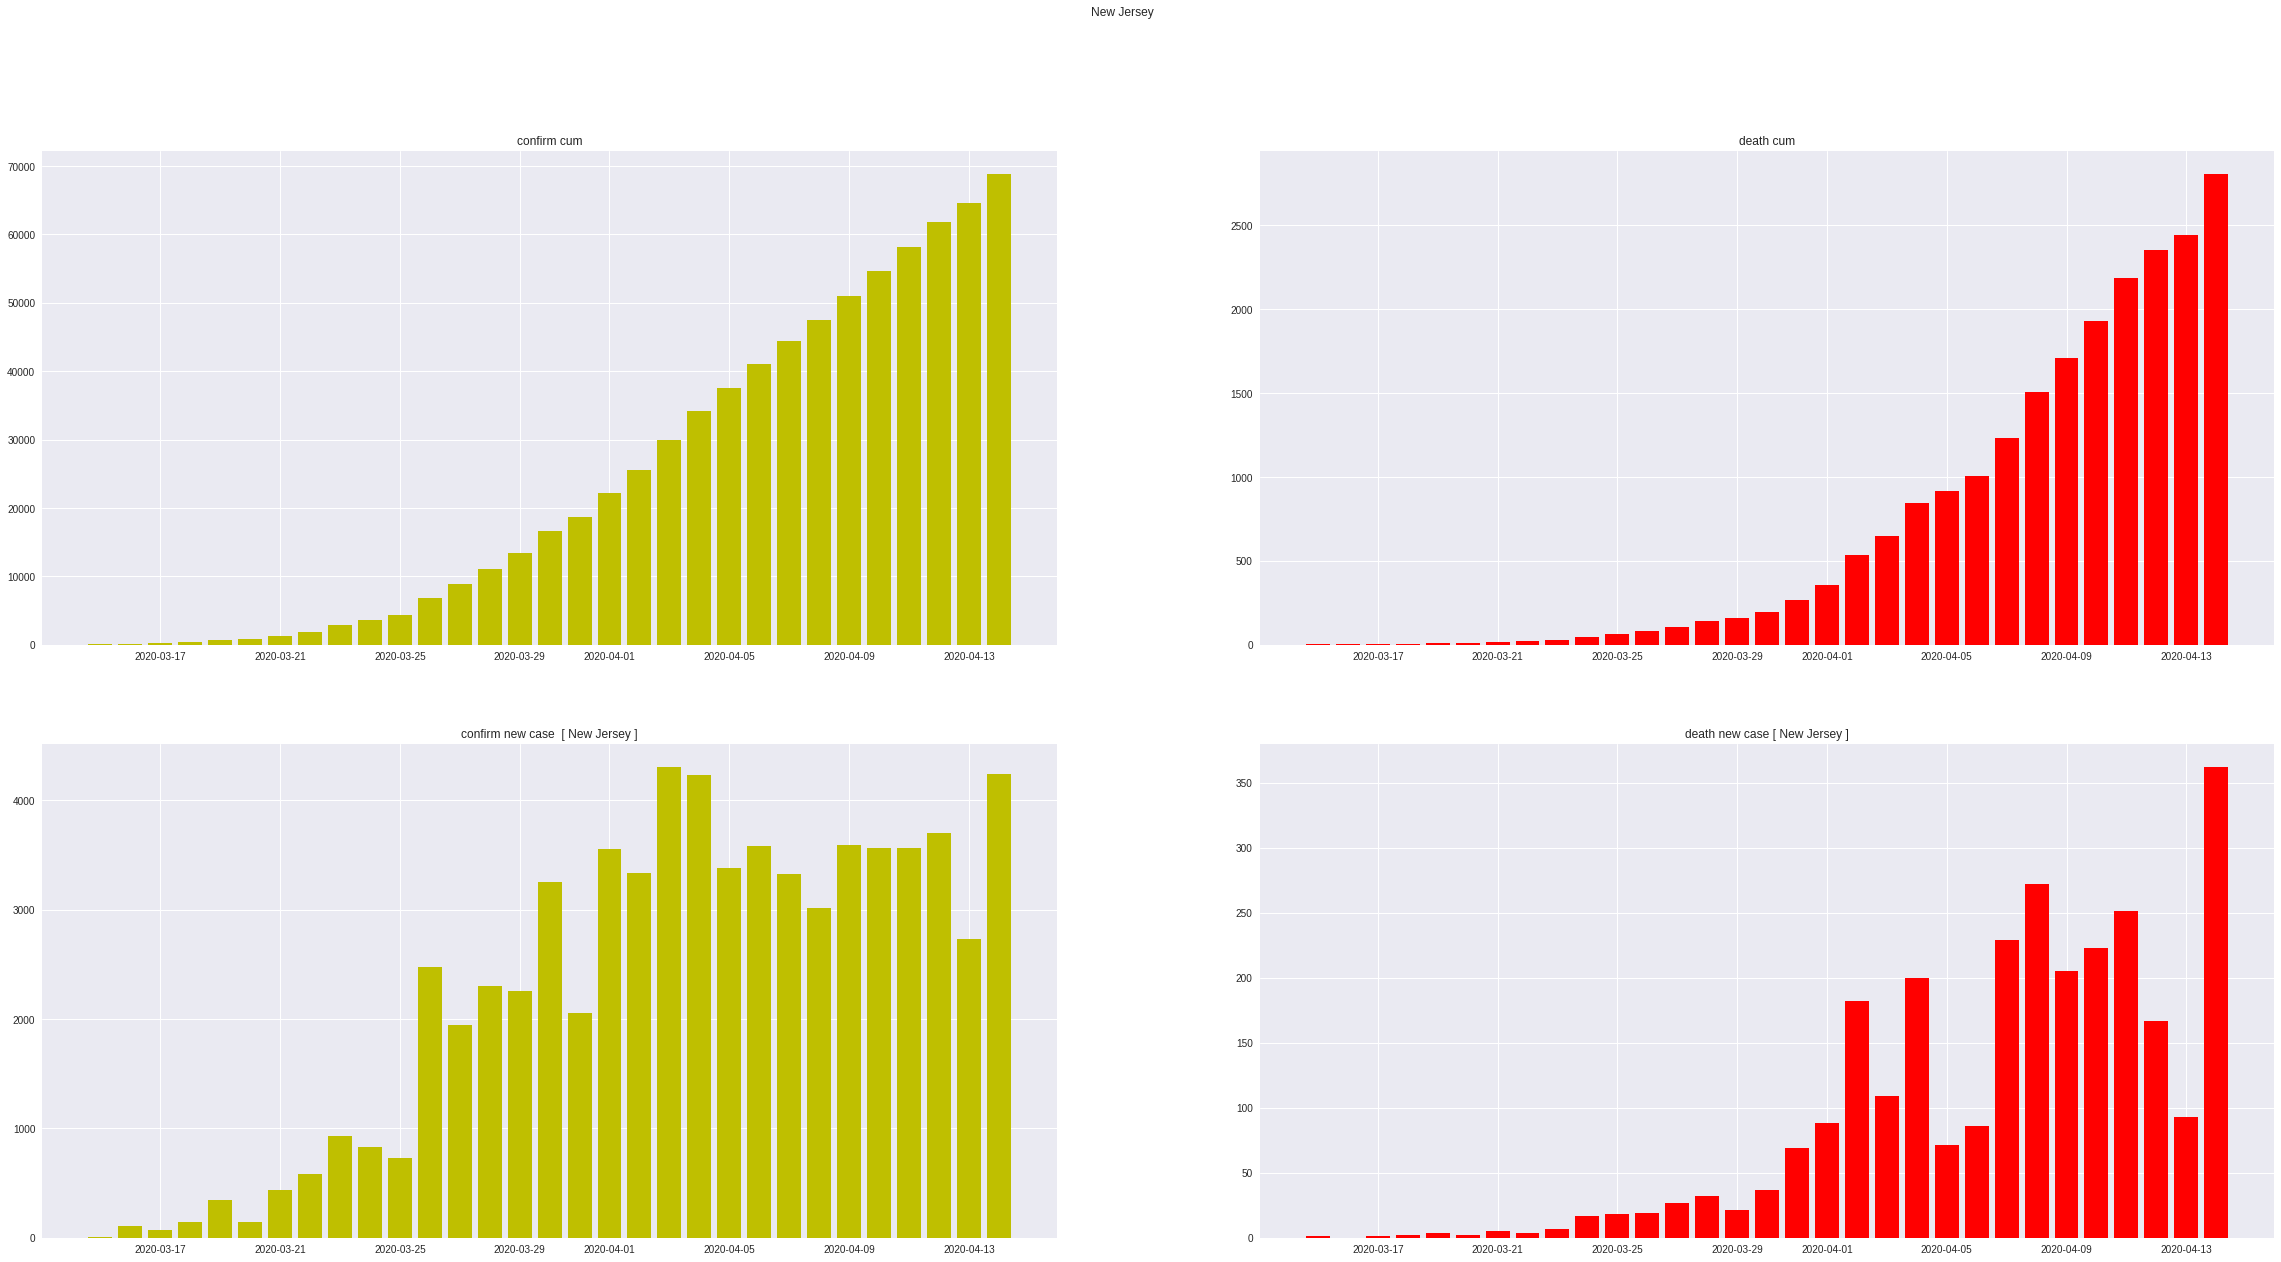

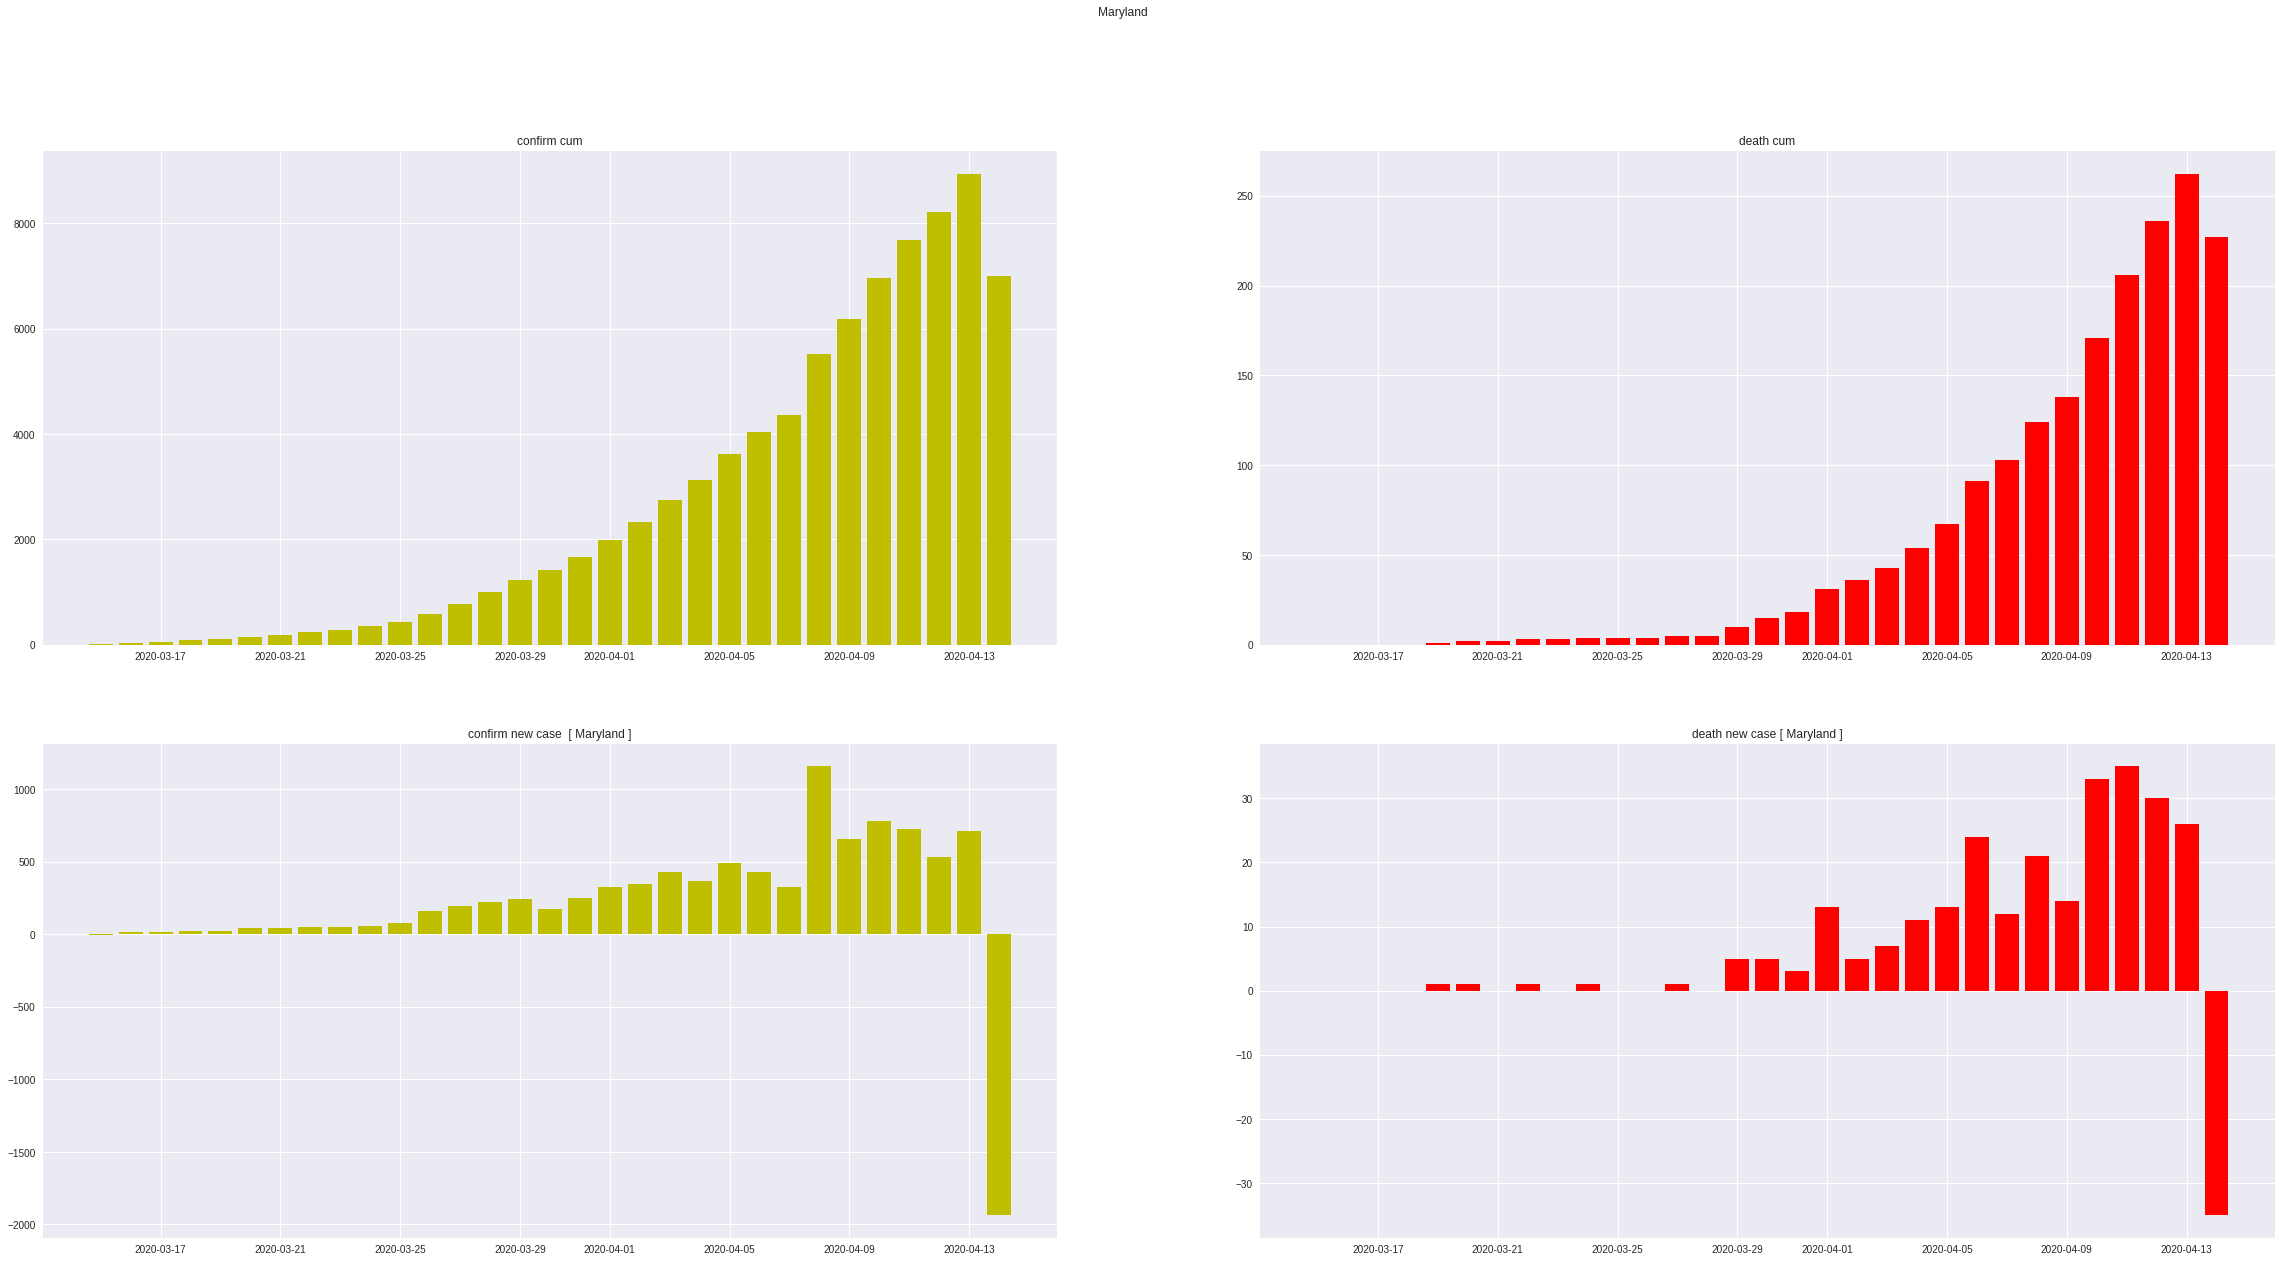

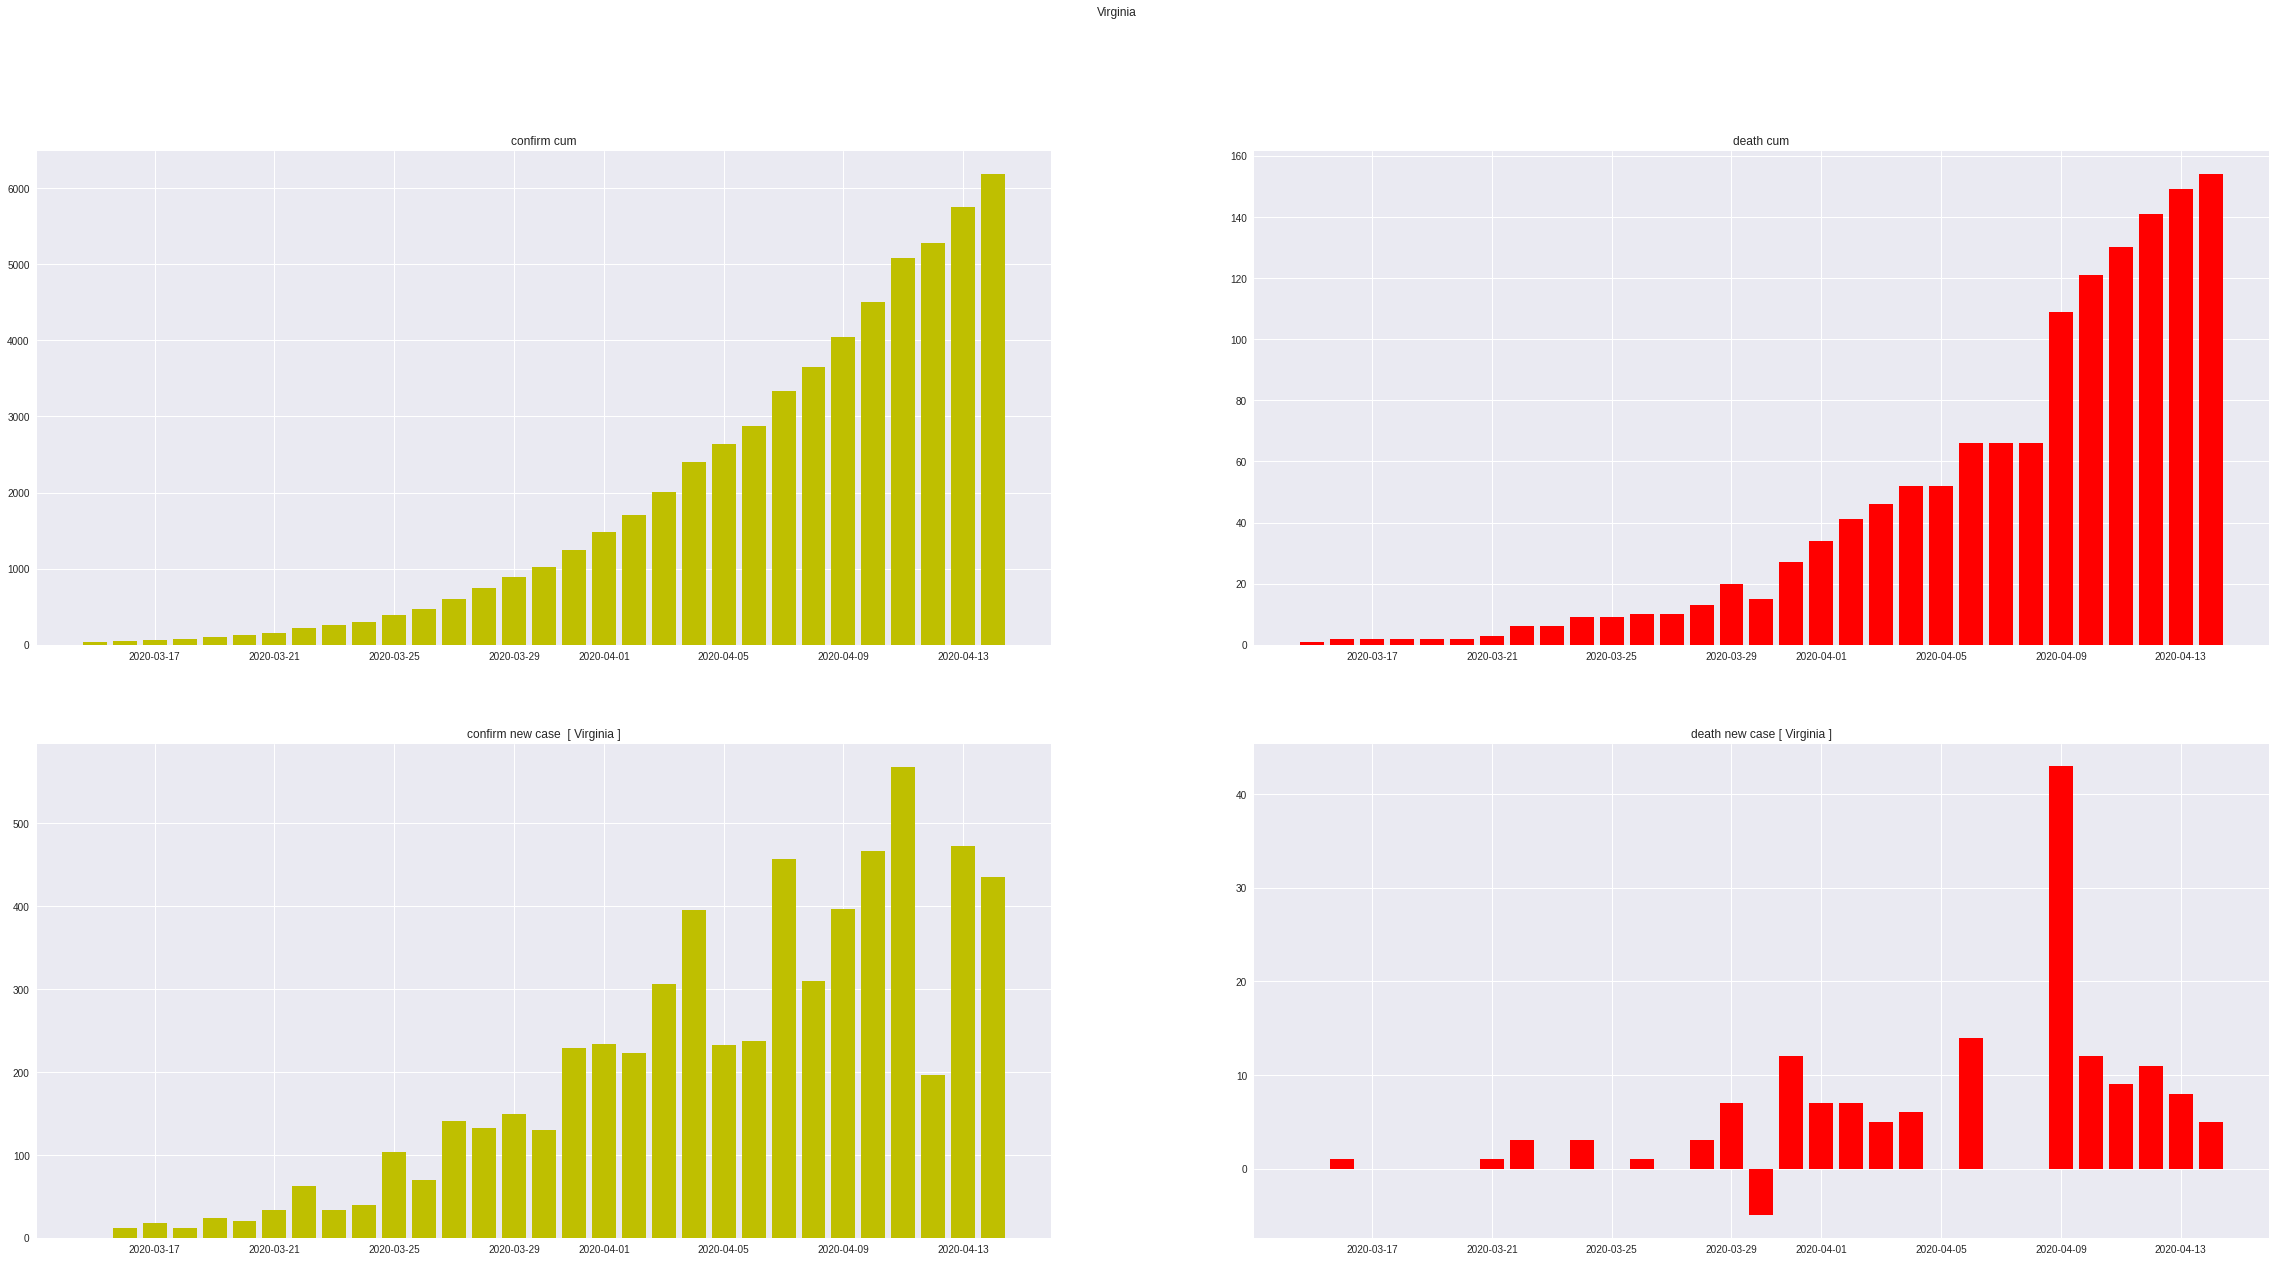

,Date,Confirm,Death,Confirm_new,Death_new
0,2020-01-22,1,0,NaN,NaN
1,2020-01-23,1,0,0.0,0.0
2,2020-01-24,2,0,1.0,1.0
3,2020-01-25,2,0,0.0,0.0
4,2020-01-26,5,0,3.0,3.0
...,...,...,...,...,...
79,2020-04-10,496530,18581,35098.0,35098.0
80,2020-04-11,526391,20457,29861.0,29861.0
81,2020-04-12,555304,22014,28913.0,28913.0
82,2020-04-13,580223,23520,24919.0,24919.0


In [0]:
country_data, state_data, data =          merge_confirm_death_US(US_File_Confirm, US_File_Death, asCumValue=True)
state_data

state_data["Confirm_new"] = state_data['Confirm'] - state_data.groupby('State')['Confirm'].shift(1)
state_data["Death_new"] = state_data['Death'] - state_data.groupby('State')['Death'].shift(1)
country_data["Confirm_new"] = country_data['Confirm'] - country_data['Confirm'].shift(1)
country_data["Death_new"] = country_data['Confirm'] - country_data['Confirm'].shift(1)

state_data.query("State=='New York'")


import matplotlib.pyplot as plt
plt.style.use('seaborn')

def plot_state (df, state):
  #fig = plt.figure(figsize=(40,20))
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=False, figsize=(40, 20))
  fig.suptitle(state, fontsize=12)
  if state == 'US':
    sel_df = df[df.Date >= "2020-03-15"]
  else:
    sel_df = df[df.State==state][df.Date >= "2020-03-15"]
  ax1.bar(sel_df.Date, sel_df["Confirm"],label=state ,color='y')
  ax1.set_title('confirm cum')
  ax2.bar(sel_df.Date, sel_df["Death"],label=state ,color='r')
  ax2.set_title('death cum')
  ax3.bar(sel_df.Date, sel_df["Confirm_new"],label=state,color='y')
  ax3.set_title('confirm new case  [ ' + state + " ]")
  ax4.bar(sel_df.Date, sel_df["Death_new"],label=state,color='r')
  ax4.set_title('death new case [ ' + state + " ]")
  plt.show()



def plot_growth(df, state, Y, usingLog=True):
  fig,ax = plt.subplots(figsize=(20, 40))

  for name in state:
      sel_df = df[df.State==name][df.Date >= "2020-03-15"]
      ax.bar(sel_df.Date, sel_df[Y],label=name)

  #ax.set_xlabel("Days after 100 cases")
  if usingLog == True:
    ax.set_ylabel("Confirm (log)")
    ax.set_yscale('log')
  else:
    ax.set_ylabel("Confirm")
  ax.legend(loc='best')
  plt.show()

def plot_growth(df, state, Y1, Y2, usingLog=True):
  fig,ax = plt.subplots(figsize=(10, 5))

  for name in state:
      sel_df = df[df.State==name][df.Date >= "2020-03-15"]
      ax.plot(sel_df.Date, sel_df[Y1],label=name)
      ax2=ax.twinx()
      ax2.bar(sel_df.Date, sel_df[Y2],label=name)
  ax.legend(loc='best')
  plt.show()

plot_state(country_data, "US")
plot_state(state_data, "New York")
plot_state(state_data, "New Jersey")
plot_state(state_data, "Maryland")
plot_state(state_data, "Virginia")


country_data
#plot_growth(state_data, ["New York"], "Confirm", "Confirm_new", False)
#plot_growth(state_data, ["New York"],  "Death", "Death_new", False)
#plot_growth(state_data, ["New York"], "Death", False)
#plot_growth(state_data, ["New York"], "Death_new", False)

In [0]:
country_data, state_data, data =          merge_confirm_death_US(US_File_Confirm, US_File_Death, asCumValue=True)
country_data_nc, state_data_nc, data_nc = merge_confirm_death_US(US_File_Confirm, US_File_Death, asCumValue=False)
population = get_population(US_File_Death)

country_data = pd.merge( country_data, country_data_nc,  on=["Date"], how="inner")
country_data.rename(columns={'Confirm_x': 'Confirm_cum', 'Confirm_y' : 'Confirm_new', 
                             "Death_x": "Death_cum", "Death_y": "Death_new"}, inplace=True)
country_data = country_data[country_data.Date >='2020-03-01']

state_data = pd.merge( state_data, state_data_nc,  on=["State", "Date"], how="inner")
state_data.rename(columns={'Confirm_x': 'Confirm_cum', 'Confirm_y' : 'Confirm_new', 
                             "Death_x": "Death_cum", "Death_y": "Death_new"}, inplace=True)
state_data = state_data[state_data.Date >='2020-03-01']

state_data

,State,Date,Confirm_cum,Death_cum,Confirm_new,Death_new
38,Alabama,2020-03-01,0,0,0,0
39,Alabama,2020-03-02,0,0,0,0
40,Alabama,2020-03-03,0,0,0,0
41,Alabama,2020-03-04,0,0,0,0
42,Alabama,2020-03-05,0,0,0,0
...,...,...,...,...,...,...
4809,Wyoming,2020-04-10,239,0,9,0
4810,Wyoming,2020-04-11,261,0,22,0
4811,Wyoming,2020-04-12,270,0,9,0
4812,Wyoming,2020-04-13,275,1,5,1


In [0]:
import matplotlib.pyplot as plt

#fig,ax = plt.subplots(figsize=(16, 10))

NY_data = state_data[state_data.State=='New York']
NY_data

MD_data = state_data[state_data.State=='Maryland']
MD_data

VA_data = state_data[state_data.State=='Virginia']
VA_data

NY_data

NJ_data = state_data[state_data.State=='New Jersey']
NY_data
#Data_Death    = read_JH_TS_file_US(US_File_Death, True)
#Data_Death[Data_Death.State=='New York']

,State,Date,Confirm_cum,Death_cum,Confirm_new,Death_new
2810,New York,2020-03-01,0,0,0,0
2811,New York,2020-03-02,1,0,1,0
2812,New York,2020-03-03,2,0,1,0
2813,New York,2020-03-04,11,0,9,0
2814,New York,2020-03-05,23,0,12,0
2815,New York,2020-03-06,31,0,8,0
2816,New York,2020-03-07,76,0,45,0
2817,New York,2020-03-08,106,0,30,0
2818,New York,2020-03-09,142,0,36,0
2819,New York,2020-03-10,150,0,8,0


50 50


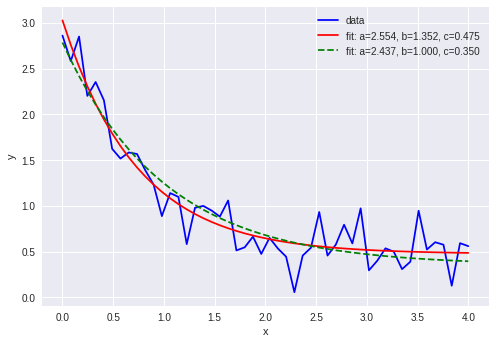

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise

country_data



plt.plot(xdata, ydata, 'b-', label='data')

print(len(xdata), xdata.size)

popt, pcov = curve_fit(func, xdata, ydata)
popt

plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
popt

plt.plot(xdata, func(xdata, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [0]:

df = country_data 
df = df[df.Date >= "2020-03-15"]
df = df.reset_index(drop=True)
df_US= df.reset_index(drop=False)
df_US["index"].values
df_US

,index,Date,Confirm_cum,Death_cum,Confirm_new,Death_new
0,0,2020-03-15,2918,60,183,8
1,1,2020-03-16,4307,84,1395,24
2,2,2020-03-17,6096,107,1795,23
3,3,2020-03-18,8873,143,2797,37
4,4,2020-03-19,14094,209,5229,66
5,5,2020-03-20,19403,258,5498,56
6,6,2020-03-21,25725,318,7058,75
7,7,2020-03-22,33634,427,8018,110
8,8,2020-03-23,43663,552,10260,132
9,9,2020-03-24,53736,706,10475,155


10 2.302585092994046 10.000000000000002
29 : 2020-04-13T00:00:00.000000000 575928.8210428157 actual= 580223
30 : 2020-04-14T00:00:00.000000000 596198.2646211967 actual= 604736
31 : 2020-04-15T00:00:00.000000000 614031.3947378587
32 : 2020-04-16T00:00:00.000000000 629571.2050825801
33 : 2020-04-17T00:00:00.000000000 642999.780708653


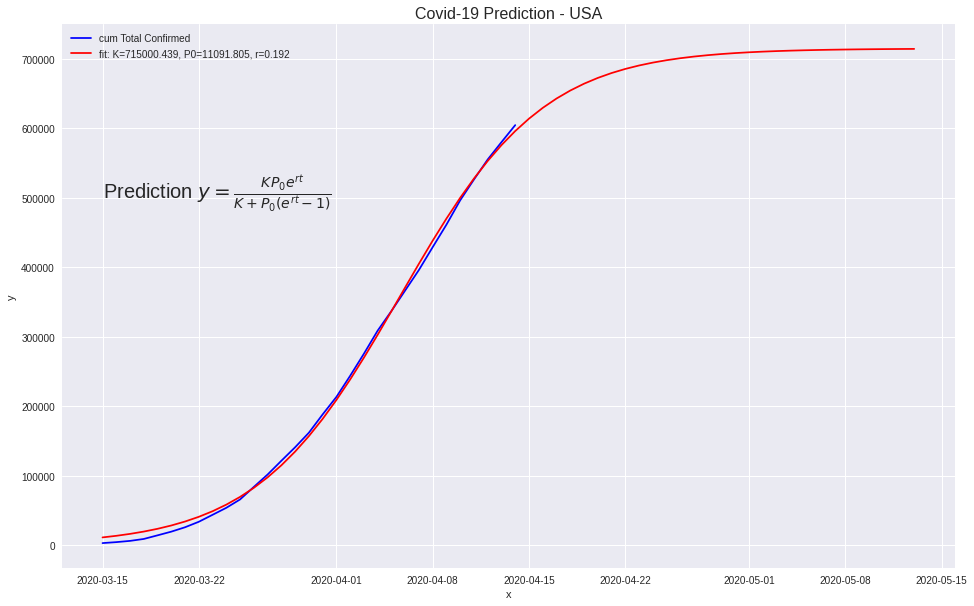

In [0]:
from datetime import datetime




def myFunc(t, K, P0, r):
  exp_value = np.exp(r*t)
  return (K*P0*exp_value)/ (K + P0*(exp_value-1))


import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit

plt.subplots(figsize=(16, 10))
#xdata = np.linspace(0, 4, 50)
#y = myFunc(xdata, 2.5, 1.3, 0.5)
#np.random.seed(1729)
##y_noise = 0.2 * np.random.normal(size=xdata.size)
#ydata = y + y_noise
xdata0 = df_US["Date"].values
xdata = df_US["index"].values
ydata = df_US["Confirm_cum"].values


#ydata = np.log(ydata)
#print(ydata)

N = len(xdata)-1
xdatanew =  range(xdata[len(xdata)-1]+1, xdata[len(xdata)-1]+30) 
xdata0new =  [xdata0[0] + np.timedelta64(int(i), 'D') for i in xdatanew]

xdatanew = np.concatenate((xdata, xdatanew), axis=None)
xdata0new = np.concatenate((xdata0, xdata0new), axis=None)

plt.plot(xdata0, ydata, 'b-', label='cum Total Confirmed')

rr = 10
print(rr, math.log(rr), math.exp(math.log(rr)))

popt, pcov = curve_fit(myFunc, xdata, ydata)
popt


print( N-1, ":", xdata0new[N-1], myFunc(N-1, *popt), "actual=", ydata[N-1])
print( N,   ":", xdata0new[N]  , myFunc(N, *popt), "actual=", ydata[N])
print( N+1, ":", xdata0new[N+1], myFunc(N+1, *popt))
print( N+2, ":", xdata0new[N+2], myFunc(N+2, *popt))
print( N+3, ":", xdata0new[N+3], myFunc(N+3, *popt))
predicted = myFunc(xdatanew, *popt)
plt.plot(xdata0new, predicted, 'r-', label='fit: K=%5.3f, P0=%5.3f, r=%5.3f' % tuple(popt))

#popt, pcov = curve_fit(myFunc, xdata, ydata, bounds=(0, [3., 1., 0.5]))
#popt

#plt.plot(xdata, logistic(xdata, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Covid-19 Prediction - USA", fontsize=16)
plt.text(xdata0[0], 500000, r'Prediction $y = \frac{KP_0e^{rt}}{K + P_0(e^{rt}-1)}$', fontsize=20, )
plt.show()


expected the function, to fit the curve
\begin{equation}
y = \frac{KP_0e^{rt}}{K + P_0(e^{rt}-1)}
\end{equation}
